<a href="https://colab.research.google.com/github/gauriverma19/Machine-Learning-in-Finance/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ARIMA FOR BMY STOCK PREDICTION**

By: Gauri Verma

Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Time-series forecasting is widely used for non-stationary data. Non-stationary data are called the data whose statistical properties e.g. the mean and standard deviation are not constant over time but instead, these metrics vary over time.

These non-stationary input data (used as input to these models) are usually called time-series. Some examples of time-series include the temperature values over time, stock price over time, price of a house over time etc. So, the input is a signal (time-series) that is defined by observations taken sequentially in time.

A famous and widely used forecasting method for time-series prediction is the AutoRegressive Integrated Moving Average (ARIMA) model. ARIMA models are capable of capturing a suite of different standard temporal structures in time-series data.

* AR: < Auto Regressive > means that the model uses the dependent relationship between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”).
* I:< Integrated > means that the model employs differencing of raw observations (e.g. it subtracts an observation from an observation at the previous time step) in order to make the time-series stationary.MA:
* MA: < Moving Average > means that the model exploits the relationship between the residual error and the observations.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
import datetime
import pandas_datareader.data as web

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#start = datetime.datetime(2009, 1, 1)
#end = datetime.datetime(2012, 1, 11)

start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2020, 7, 31)

df = web.DataReader("BMY", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-27,58.619999,57.349998,57.549999,58.049999,12372000.0,57.616718
2020-07-28,59.820000,58.240002,58.549999,59.430000,9816300.0,58.986420
2020-07-29,59.400002,58.590000,59.160000,59.150002,7357900.0,58.708511
2020-07-30,59.150002,58.340000,58.799999,58.869999,7175200.0,58.430595
2020-07-31,59.090000,57.770000,58.880001,58.660000,10443000.0,58.222164


The standard ARIMA models expect as input parameters 3 arguments i.e. p,d,q.
* p is the number of lag observations.
* d is the degree of differencing.
* q is the size/width of the moving average window.

In [ ]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Close'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Close'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

In [ ]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

# Dickey- Fuller Test

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [ ]:
df_testing = pd.DataFrame(np.log(df.Close).diff().diff(12))
adf_check(df_testing.Close.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -12.204248233052155
p-value : 1.2036774027139855e-22
Number of Lags Used : 23
Number of Observations Used : 1116
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


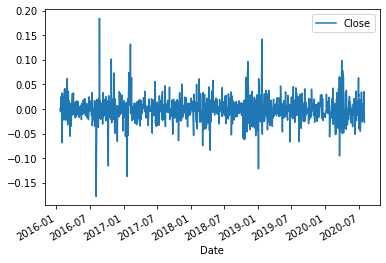

In [ ]:
# print(df_testing.to_string())
df_testing.plot()

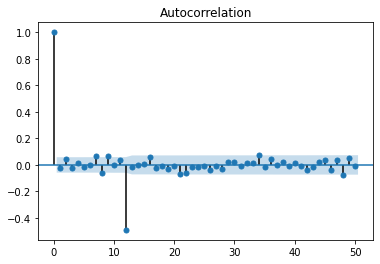

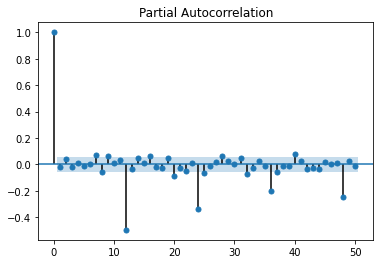

In [ ]:
ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

In [ ]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Close))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

The RMSE is : 0.024945448204610254 , Value of p :  1
The RMSE is : 0.025024533635199464 , Value of p :  2
The RMSE is : 0.025009298125754 , Value of p :  3
The RMSE is : 0.025003127554381954 , Value of p :  4
The RMSE is : 0.02507876926495221 , Value of p :  5
The RMSE is : 0.025218559238084283 , Value of p :  6
The RMSE is : 0.0250743854251008 , Value of p :  7
The RMSE is : 0.024962010467394262 , Value of p :  8
The RMSE is : 0.024814185744604478 , Value of p :  9
The RMSE is : 0.024962530417898757 , Value of p :  10
The RMSE is : 0.02500626673109561 , Value of p :  11
The RMSE is : 0.022556932738841372 , Value of p :  12
The RMSE is : 0.022573852985318374 , Value of p :  13
The RMSE is : 0.022820058799188154 , Value of p :  14
The RMSE is : 0.02292917471788165 , Value of p :  15
The RMSE is : 0.02282383477080421 , Value of p :  16
The RMSE is : 0.02284437417741187 , Value of p :  17
The RMSE is : 0.022850772590996993 , Value of p :  18
The RMSE is : 0.022815317941256377 , Value of p

In [ ]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Close))

The RMSE is : 0.022536467747991916 , Value of p :  20


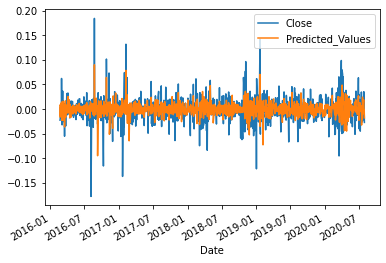

In [ ]:
df_c = pd.concat([df_train,df_test])
df_c[['Close','Predicted_Values']].plot()

In [ ]:
res = pd.DataFrame()
res['Residuals'] = df_c.Close - df_c.Predicted_Values


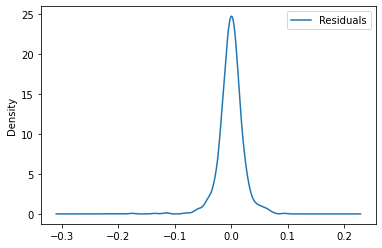

In [ ]:
res.plot(kind='kde')


The RMSE is : 0.022796222312035826 , Value of q :  1
The RMSE is : 0.022802042921331266 , Value of q :  2
The RMSE is : 0.022803282914621657 , Value of q :  3
The RMSE is : 0.022777045611615573 , Value of q :  4
The RMSE is : 0.022757393517779164 , Value of q :  5
The RMSE is : 0.02279025883868284 , Value of q :  6
The RMSE is : 0.022808804763461657 , Value of q :  7
The RMSE is : 0.022926952977310327 , Value of q :  8
The RMSE is : 0.022947503866871465 , Value of q :  9
The RMSE is : 0.02285634090754451 , Value of q :  10
The RMSE is : 0.02286489724852436 , Value of q :  11
The RMSE is : 0.0227983840000788 , Value of q :  12
5


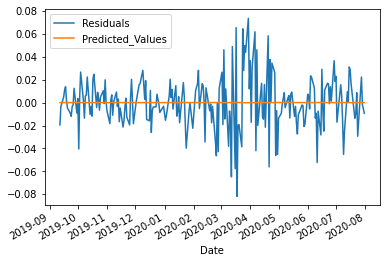

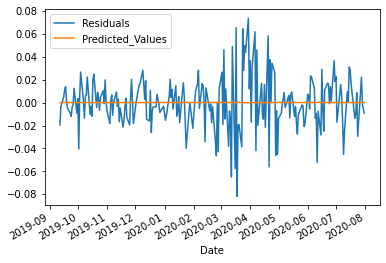

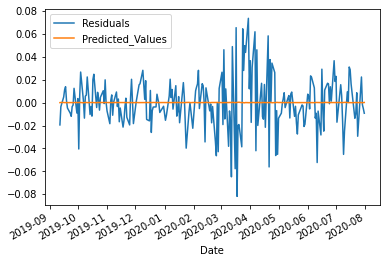

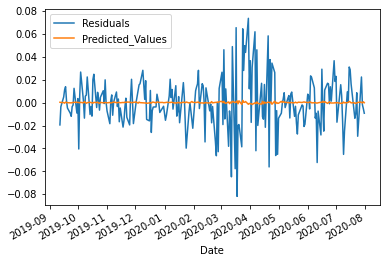

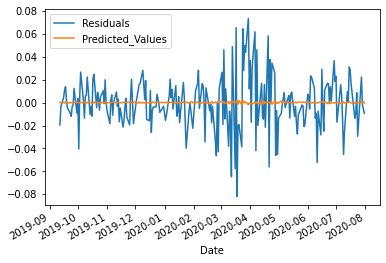

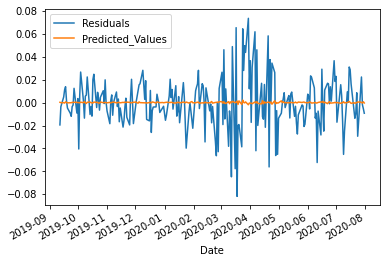

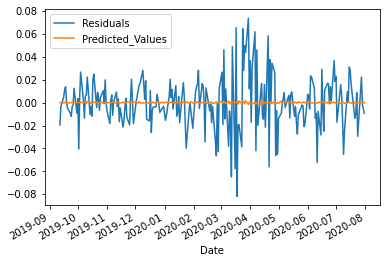

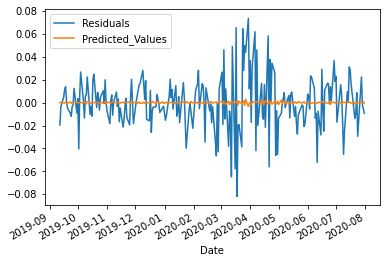

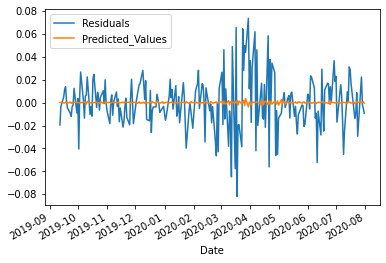

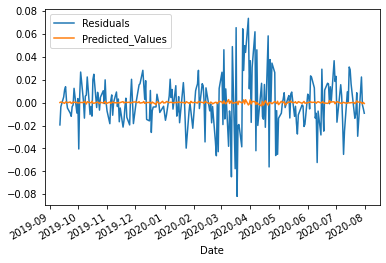

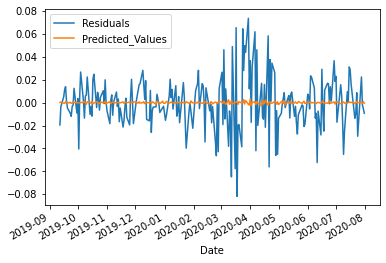

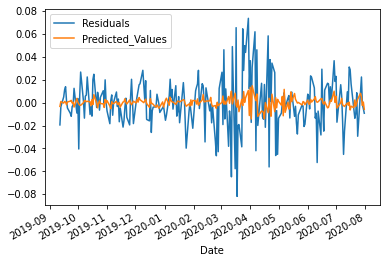

In [ ]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
print(best_q)

The RMSE is : 0.022757393517779164 , Value of q :  5
[[-0.00169066]
 [-0.0004292 ]
 [ 0.00040314]
 [-0.02316285]
 [ 0.00796744]]
[7.32244968e-05]


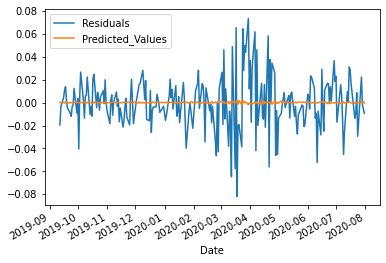

In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [ ]:
res_c = pd.concat([res_train,res_test])


In [ ]:
df_c.Predicted_Values += res_c.Predicted_Values


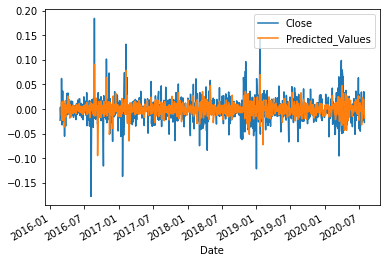

In [ ]:
df_c[['Close','Predicted_Values']].plot()


In [ ]:
df_c.Close += np.log(df).shift(1).Close
df_c.Close += np.log(df).diff().shift(12).Close
df_c.Predicted_Values += np.log(df).shift(1).Close 
df_c.Predicted_Values += np.log(df).diff().shift(12).Close
df_c.Close = np.exp(df_c.Close)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

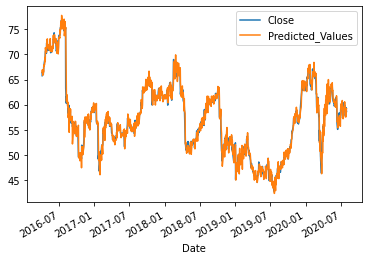

In [ ]:
df_c.iloc[30:,:][['Close','Predicted_Values']].plot()


# Conclusion

We split the training dataset into train and test sets and we use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecasting procedure is required given the dependence on observations in prior time steps for differencing and the AR model. To this end, we re-create the ARIMA model after each new observation is received.

